In [64]:
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
seed(1)
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tensorflow
import sklearn
tensorflow.random.set_seed(1)
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 1. Data Preparation
## 1.1. Get the data and get it ready to use
Delete useless columns, change categories values...

In [361]:
df=pd.read_csv("./challenge_youtube_toxic.csv", sep=";",encoding = 'latin1')
df=df.drop(['video_id','video_id_court','channel_id','channel_name','Unnamed: 27','nbrMotInsulteMoyenne'],axis=1)

'''
The categories-fields are useful data for us to analyse, 
but we cannot leave them as they are to compute a neural network algorithm.
We are then going to create one column for each value, and fill it with 0 or 1
'''

df['Core']=(df['categorie_new']=='Core')*1
df['Niche']=(df['categorie_new']=='Niche')*1
df['Partisan']=(df['categorie_new']=='Partisan')*1
df['Pure Players']=(df['categ_inst']=='Pure Players')*1
df['TV']=(df['categ_inst']=='TV')*1
df['Presse_regionale']=(df['categ_inst']=='Presse_regionale')*1
df['Presse nationale']=(df['categ_inst']=='Presse nationale')*1
df['Presse magazine']=(df['categ_inst']=='Presse magazine')*1
df['Alternatif']=(df['categ_inst']=='Alternatif')*1

df=df.drop(['categ_inst','categorie_new'],axis=1)

def convert_into_float(string):
    if type(string)==int:
        return string
    return float(string.replace(',','.'))

df=df.applymap(convert_into_float)

## 1.2. Separate the train and the validation datasets

In [362]:
y=df['nbrMotInsulte'].to_numpy()
x=df.drop(['nbrMotInsulte'],axis=1).to_numpy()

X_train, X_val, y_train, y_val = train_test_split(x, y)

## 1.3. Feature Scaling

In [363]:
y_train=np.reshape(y_train, (-1,1))
y_val=np.reshape(y_val, (-1,1))
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

print(scaler_x.fit(X_train))
xtrain_scale=scaler_x.transform(X_train)
print(scaler_x.fit(X_val))
xval_scale=scaler_x.transform(X_val)

print(scaler_y.fit(y_train))
ytrain_scale=scaler_y.transform(y_train)
print(scaler_y.fit(y_val))
yval_scale=scaler_y.transform(y_val)

MinMaxScaler()
MinMaxScaler()
MinMaxScaler()
MinMaxScaler()


# 2. Neural network : models comparison

In this section, we are going to try several different neural networks models, and change the parameters (batch, epoch) so that the model can perform best
## 2.1. First model : 1 hidden layer with many neurones

In [358]:
# A. Setting up the model

num_features=x.shape[1]
hidden_layers=x.shape[0]/(num_features+1)

model = Sequential()
model.add(Dense(num_features, input_dim=num_features, kernel_initializer='normal', activation='relu'))
model.add(Dense(hidden_layers, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_79 (Dense)             (None, 1589)              46081     
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 1590      
Total params: 48,483
Trainable params: 48,483
Non-trainable params: 0
_________________________________________________________________


In [359]:
# B. Fitting the model
epoch = 30
batch = 150
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae']) # mean_squared_error (mse) and mean_absolute_error (mae) are our loss functions
history=model.fit(xtrain_scale, ytrain_scale, epochs=epoch, batch_size=batch, verbose=1, validation_split=0.2)
predictions = model.predict(xval_scale)
prediction_unscaled=scaler_y.inverse_transform(predictions)
sklearn.metrics.mean_squared_error(y_val, prediction_unscaled)

Epoch 1/30
185/185 [==============================] - 0s 2ms/step - loss: 5.0100e-05 - mse: 5.0100e-05 - mae: 0.0026 - val_loss: 8.2606e-05 - val_mse: 8.2606e-05 - val_mae: 0.0014
Epoch 2/30
185/185 [==============================] - 0s 2ms/step - loss: 1.9641e-05 - mse: 1.9641e-05 - mae: 0.0013 - val_loss: 2.9712e-05 - val_mse: 2.9712e-05 - val_mae: 0.0013
Epoch 3/30
185/185 [==============================] - 0s 2ms/step - loss: 1.4663e-05 - mse: 1.4663e-05 - mae: 0.0013 - val_loss: 1.5196e-05 - val_mse: 1.5196e-05 - val_mae: 8.9784e-04
Epoch 4/30
185/185 [==============================] - 0s 1ms/step - loss: 1.2430e-05 - mse: 1.2430e-05 - mae: 0.0013 - val_loss: 1.0022e-04 - val_mse: 1.0022e-04 - val_mae: 0.0042
Epoch 5/30
185/185 [==============================] - 0s 2ms/step - loss: 1.5873e-05 - mse: 1.5873e-05 - mae: 0.0016 - val_loss: 1.2728e-05 - val_mse: 1.2728e-05 - val_mae: 0.0014
Epoch 6/30
185/185 [==============================] - 0s 2ms/step - loss: 1.1857e-05 - mse: 1.18

1195.433947227714

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


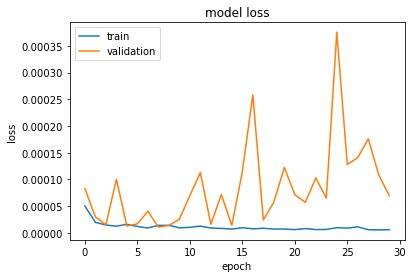

In [360]:
# C.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
When we read this graph, we realize that we are overfitting the dataset 

## 2.2. Simpler model : 1 hidden layer, and less neurones in the hidden layer 

In [370]:
# A. Setting up the model
num_features=x.shape[1]
hidden_layers=2/3*(num_features+1)

simpler_model = Sequential()
simpler_model.add(Dense(num_features, input_dim=num_features, kernel_initializer='normal', activation='relu'))
simpler_model.add(Dense(hidden_layers, activation='relu'))
simpler_model.add(Dense(1, activation='linear'))
simpler_model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_85 (Dense)             (None, 19)                551       
_________________________________________________________________
dense_86 (Dense)             (None, 1)                 20        
Total params: 1,383
Trainable params: 1,383
Non-trainable params: 0
_________________________________________________________________


In [371]:
# B. Fitting the model

epoch=100
batch=int(x.shape[0]/7)

simpler_model.compile(loss='mse', optimizer='adam', metrics=['mse','mae']) # mean_squared_error (mse) and mean_absolute_error (mae) are our loss functions
history=simpler_model.fit(xtrain_scale, ytrain_scale, epochs=epoch, batch_size=batch, verbose=0, validation_split=0.2)
predictions = simpler_model.predict(xval_scale)

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


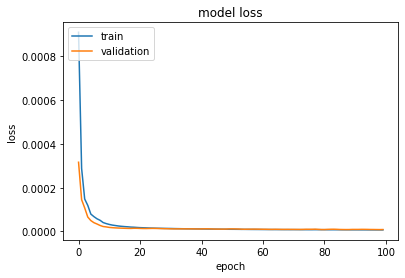

In [373]:
# C.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [374]:
prediction_unscaled=scaler_y.inverse_transform(predictions)
sklearn.metrics.mean_squared_error(y_val, prediction_unscaled)

639.3210202647533

In [381]:
#Let's have a look at the 50 first rows to see how well we performed

comparison=pd.concat([pd.DataFrame(prediction_unscaled).rename(columns={0:'prediction'}),pd.DataFrame(y_val).rename(columns={0:'y_val'})],axis=1)

#We add a new indicator, the absolute difference
comparison['absolute_diff']=comparison.apply(lambda x: math.sqrt((x['prediction']-x['y_val'])**2),axis=1)


In [382]:
comparison.describe()

,prediction,y_val,absolute_diff
count,11526.000000,11526.000000,11526.000000
mean,9.718480,9.013535,5.035399
std,53.869987,45.199434,24.779408
min,-39.879333,0.000000,0.000080
25%,0.145916,0.000000,0.417692
50%,0.788015,0.000000,1.021773
75%,3.058020,3.000000,2.591976
max,1414.321533,1730.000000,788.584961


In [179]:
# We then compute the mean squared error for each couple
pred_pd=pd.DataFrame.from_dict(Prediction_dict)
def unscaling(pred):
    return sklearn.metrics.mean_squared_error(y_val, scaler_y.inverse_transform(pred))
pred_pd.applymap(unscaling)

,30,50,100,200,300
100,1024.441245,1421.479784,905.875125,875.880420,668.182360
150,2664.857583,1493.969552,995.429773,623.441188,621.947911
200,2670.713479,1233.486516,776.070377,579.056118,682.451946
300,2388.307801,995.730670,889.332610,592.463137,716.568578
500,1906.926130,895.660283,989.014911,619.118164,767.312778


We find that the values that best minimize the mean squared error are epoch = 200, batch=200

In [180]:
predictions=Prediction_dict[200][200]
history=History_dict[200][200]

# Results Analysis

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


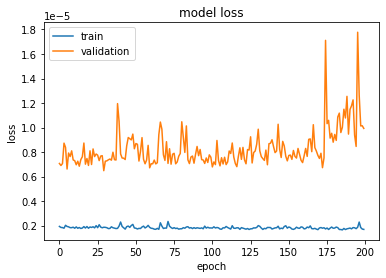

In [181]:
#6.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [182]:
prediction_unscaled=scaler_y.inverse_transform(predictions)
sklearn.metrics.mean_squared_error(y_val, prediction_unscaled)

579.0561184201813

In [190]:
#Let's have a look at the 50 first rows to see how well we performed

comparaison=pd.concat([pd.DataFrame(prediction_unscaled).rename(columns={0:'prediction'}),pd.DataFrame(y_val).rename(columns={0:'y_val'})],axis=1)

#We add a new indicator, the absolute difference
comparaison['absolute_diff']=comparaison.apply(lambda x: (x['prediction']-x['y_val'])**2,axis=1)
comparaison.head(50)

,prediction,y_val,absolute_diff
0,69.960953,110,1603.125304
1,0.337949,0,0.114210
2,-0.453255,0,0.205440
3,16.759592,13,14.134532
4,0.351359,0,0.123453
5,0.048618,0,0.002364
6,0.273098,0,0.074583
7,-0.214559,3,10.333391
8,-0.148235,0,0.021974
9,-0.453255,2,6.018462


In [184]:
comparaison.describe()

,prediction,y_val,absolute_diff
count,11526.000000,11526.000000,1.152600e+04
mean,8.518891,8.973712,5.790561e+02
std,51.864639,49.614875,1.036217e+04
min,-13.170770,0.000000,8.241259e-08
25%,-0.453255,0.000000,2.054404e-01
50%,0.194038,0.000000,2.316902e-01
75%,2.431689,3.000000,4.584697e+00
max,2480.384766,2653.000000,5.737221e+05


In [185]:
comparaison['absolute_diff'].sum()/y_val.size

579.0561184201813

In [191]:
comparaison['prediction_rounded']=comparaison['prediction'].apply(lambda x: round(x))
comparaison['diff_rounded']=comparaison.apply(lambda x: (x['prediction_rounded']-x['y_val'])**2,axis=1)

In [187]:
#Let's have a look at how well we improved the model with this improvement
comparaison.describe()

,prediction,y_val,absolute_diff,prediction_rounded,diff_rounded
count,11526.000000,11526.000000,1.152600e+04,11526.000000,11526.000000
mean,8.518891,8.973712,5.790561e+02,8.681069,578.909509
std,51.864639,49.614875,1.036217e+04,51.835997,10358.703288
min,-13.170770,0.000000,8.241259e-08,-13.000000,0.000000
25%,-0.453255,0.000000,2.054404e-01,0.000000,0.000000
50%,0.194038,0.000000,2.316902e-01,0.000000,0.000000
75%,2.431689,3.000000,4.584697e+00,2.000000,4.000000
max,2480.384766,2653.000000,5.737221e+05,2480.000000,573049.000000


In [194]:
def no_negatives(x):
    if x<0:
        return 0
    return x
comparaison['prediction_no_negatives']=comparaison['prediction_rounded'].apply(lambda x: no_negatives(x))
comparaison['diff_no_negatives']=comparaison.apply(lambda x: (x['prediction_no_negatives']-x['y_val'])**2,axis=1)

In [195]:
#Let's have a look at how well we improved the model with this improvement
comparaison.describe()

,prediction,y_val,absolute_diff,prediction_rounded,diff_rounded,prediction_no_negatives,diff_no_negatives
count,11526.000000,11526.000000,1.152600e+04,11526.000000,11526.000000,11526.000000,11526.000000
mean,8.518891,8.973712,5.790561e+02,8.681069,578.909509,8.684539,578.873937
std,51.864639,49.614875,1.036217e+04,51.835997,10358.703288,51.835114,10358.705042
min,-13.170770,0.000000,8.241259e-08,-13.000000,0.000000,0.000000,0.000000
25%,-0.453255,0.000000,2.054404e-01,0.000000,0.000000,0.000000,0.000000
50%,0.194038,0.000000,2.316902e-01,0.000000,0.000000,0.000000,0.000000
75%,2.431689,3.000000,4.584697e+00,2.000000,4.000000,2.000000,4.000000
max,2480.384766,2653.000000,5.737221e+05,2480.000000,573049.000000,2480.000000,573049.000000


# New Model with 2 hidden layers

In [197]:
#4. Setting up the model
num_features=x.shape[1]
hidden_layers=x.shape[0]/(num_features+1)

new_model = Sequential()
new_model.add(Dense(num_features, input_dim=num_features, kernel_initializer='normal', activation='relu'))
new_model.add(Dense(hidden_layers, activation='relu'))
new_model.add(Dense(hidden_layers, activation='relu'))
new_model.add(Dense(1, activation='linear'))
new_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_14 (Dense)             (None, 1589)              46081     
_________________________________________________________________
dense_15 (Dense)             (None, 1589)              2526510   
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 1590      
Total params: 2,574,993
Trainable params: 2,574,993
Non-trainable params: 0
_________________________________________________________________


In [205]:
epoch=150
batch=150

new_model.compile(loss='mse', optimizer='adam', metrics=['mse','mae']) # mean_squared_error (mse) and mean_absolute_error (mae) are our loss functions
history=model.fit(xtrain_scale, ytrain_scale, epochs=epoch, batch_size=batch, verbose=1, validation_split=0.2)
predictions = model.predict(xval_scale)

Epoch 1/150
185/185 [==============================] - 0s 2ms/step - loss: 1.7179e-06 - mse: 1.7179e-06 - mae: 5.1864e-04 - val_loss: 8.5063e-06 - val_mse: 8.5063e-06 - val_mae: 5.6022e-04
Epoch 2/150
185/185 [==============================] - 0s 1ms/step - loss: 1.5437e-06 - mse: 1.5437e-06 - mae: 4.9452e-04 - val_loss: 8.6524e-06 - val_mse: 8.6524e-06 - val_mae: 6.2150e-04
Epoch 3/150
185/185 [==============================] - 0s 2ms/step - loss: 1.6078e-06 - mse: 1.6078e-06 - mae: 5.0499e-04 - val_loss: 8.3734e-06 - val_mse: 8.3734e-06 - val_mae: 5.6362e-04
Epoch 4/150
185/185 [==============================] - 0s 2ms/step - loss: 1.4384e-06 - mse: 1.4384e-06 - mae: 4.7912e-04 - val_loss: 8.4773e-06 - val_mse: 8.4773e-06 - val_mae: 7.2173e-04
Epoch 5/150
185/185 [==============================] - 0s 2ms/step - loss: 1.4692e-06 - mse: 1.4692e-06 - mae: 4.9821e-04 - val_loss: 8.9328e-06 - val_mse: 8.9328e-06 - val_mae: 5.6596e-04
Epoch 6/150
185/185 [==============================] - 

185/185 [==============================] - 0s 1ms/step - loss: 1.4264e-06 - mse: 1.4264e-06 - mae: 4.7730e-04 - val_loss: 1.1524e-05 - val_mse: 1.1524e-05 - val_mae: 6.6415e-04
Epoch 45/150
185/185 [==============================] - 0s 1ms/step - loss: 1.5099e-06 - mse: 1.5099e-06 - mae: 5.0408e-04 - val_loss: 8.8362e-06 - val_mse: 8.8362e-06 - val_mae: 7.9485e-04
Epoch 46/150
185/185 [==============================] - 0s 1ms/step - loss: 1.6165e-06 - mse: 1.6165e-06 - mae: 4.9785e-04 - val_loss: 1.0163e-05 - val_mse: 1.0163e-05 - val_mae: 5.8929e-04
Epoch 47/150
185/185 [==============================] - 0s 1ms/step - loss: 1.6768e-06 - mse: 1.6768e-06 - mae: 4.8795e-04 - val_loss: 1.0967e-05 - val_mse: 1.0967e-05 - val_mae: 8.7905e-04
Epoch 48/150
185/185 [==============================] - 0s 1ms/step - loss: 2.0488e-06 - mse: 2.0488e-06 - mae: 5.7373e-04 - val_loss: 9.7983e-06 - val_mse: 9.7983e-06 - val_mae: 6.0715e-04
Epoch 49/150
185/185 [==============================] - 0s 1ms/

185/185 [==============================] - 0s 2ms/step - loss: 1.6489e-06 - mse: 1.6489e-06 - mae: 5.0160e-04 - val_loss: 1.2488e-05 - val_mse: 1.2488e-05 - val_mae: 6.4450e-04
Epoch 88/150
185/185 [==============================] - 0s 1ms/step - loss: 1.5803e-06 - mse: 1.5803e-06 - mae: 4.9453e-04 - val_loss: 1.8026e-05 - val_mse: 1.8026e-05 - val_mae: 7.5018e-04
Epoch 89/150
185/185 [==============================] - 0s 2ms/step - loss: 1.6865e-06 - mse: 1.6865e-06 - mae: 5.1728e-04 - val_loss: 1.5907e-05 - val_mse: 1.5907e-05 - val_mae: 7.4585e-04
Epoch 90/150
185/185 [==============================] - 0s 1ms/step - loss: 1.6372e-06 - mse: 1.6372e-06 - mae: 5.0730e-04 - val_loss: 1.5920e-05 - val_mse: 1.5920e-05 - val_mae: 6.3258e-04
Epoch 91/150
185/185 [==============================] - 0s 1ms/step - loss: 1.5100e-06 - mse: 1.5100e-06 - mae: 4.9541e-04 - val_loss: 1.4062e-05 - val_mse: 1.4062e-05 - val_mae: 0.0011
Epoch 92/150
185/185 [==============================] - 0s 2ms/step

185/185 [==============================] - 0s 1ms/step - loss: 1.7215e-06 - mse: 1.7215e-06 - mae: 5.1553e-04 - val_loss: 9.8326e-06 - val_mse: 9.8326e-06 - val_mae: 6.1941e-04
Epoch 131/150
185/185 [==============================] - 0s 2ms/step - loss: 1.4753e-06 - mse: 1.4753e-06 - mae: 4.6547e-04 - val_loss: 8.1117e-06 - val_mse: 8.1117e-06 - val_mae: 7.5008e-04
Epoch 132/150
185/185 [==============================] - 0s 2ms/step - loss: 1.4730e-06 - mse: 1.4730e-06 - mae: 4.9118e-04 - val_loss: 8.7948e-06 - val_mse: 8.7948e-06 - val_mae: 5.8028e-04
Epoch 133/150
185/185 [==============================] - 0s 1ms/step - loss: 1.4494e-06 - mse: 1.4494e-06 - mae: 4.8879e-04 - val_loss: 1.0767e-05 - val_mse: 1.0767e-05 - val_mae: 6.1297e-04
Epoch 134/150
185/185 [==============================] - 0s 1ms/step - loss: 1.5207e-06 - mse: 1.5207e-06 - mae: 5.3497e-04 - val_loss: 1.0106e-05 - val_mse: 1.0106e-05 - val_mae: 6.4428e-04
Epoch 135/150
185/185 [==============================] - 0s

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


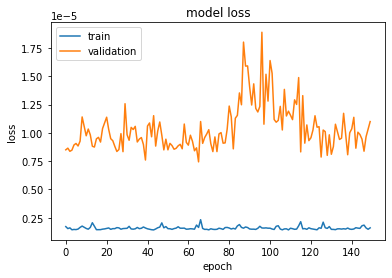

In [214]:
#6.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [202]:
prediction_unscaled=scaler_y.inverse_transform(predictions)
sklearn.metrics.mean_squared_error(y_val, prediction_unscaled)

740.9120461477172

In [203]:
mean_absolute_error(y_val, prediction_unscaled)

4.730353311560731

In [204]:
mean_squared_error(y_val, prediction_unscaled)

740.9120461477172

# Simpler Model

In [350]:
#4. Setting up the model
num_features=x.shape[1]
hidden_layers=2/3*(num_features+1)

simpler_model = Sequential()
simpler_model.add(Dense(num_features, input_dim=num_features, kernel_initializer='normal', activation='relu'))
simpler_model.add(Dense(hidden_layers, activation='relu'))
simpler_model.add(Dense(1, activation='linear'))
simpler_model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_73 (Dense)             (None, 19)                551       
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 20        
Total params: 1,383
Trainable params: 1,383
Non-trainable params: 0
_________________________________________________________________


In [351]:
epoch=100
batch=int(x.shape[0]/7)

simpler_model.compile(loss='mse', optimizer='adam', metrics=['mse','mae']) # mean_squared_error (mse) and mean_absolute_error (mae) are our loss functions
history=simpler_model.fit(xtrain_scale, ytrain_scale, epochs=epoch, batch_size=batch, verbose=0, validation_split=0.2)
predictions = simpler_model.predict(xval_scale)
We tested with batch=int(x.shape[0]/50), and it resulted in overfitting, so with a dichotomy method, we landed at batch=int(x.shape[0]/7), which is 6586

We tested with batch=int(x.shape[0]/50), and it resulted in overfitting, so with a dichotomy method, we landed at batch=int(x.shape[0]/7), which is 6586

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


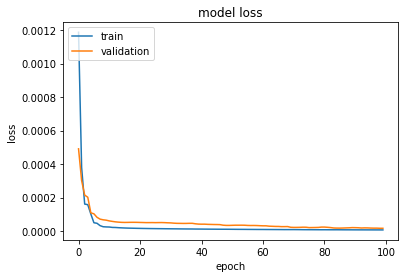

In [353]:
#6.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [354]:
prediction_unscaled=scaler_y.inverse_transform(predictions)
sklearn.metrics.mean_squared_error(y_val, prediction_unscaled)

505.3003592731998

In [355]:
batch

6586

## Just for fun : Testing with a new batch value (much lower) ==> overfitting

In [243]:
epoch=100
batch=500

simpler_model.compile(loss='mse', optimizer='adam', metrics=['mse','mae']) # mean_squared_error (mse) and mean_absolute_error (mae) are our loss functions
history=simpler_model.fit(xtrain_scale, ytrain_scale, epochs=epoch, batch_size=batch, verbose=0, validation_split=0.2)
predictions = simpler_model.predict(xval_scale)

Epoch 1/100
56/56 [==============================] - 0s 3ms/step - loss: 1.3785e-05 - mse: 1.3785e-05 - mae: 0.0015 - val_loss: 1.7399e-05 - val_mse: 1.7399e-05 - val_mae: 0.0011
Epoch 2/100
56/56 [==============================] - 0s 1ms/step - loss: 1.0300e-05 - mse: 1.0300e-05 - mae: 0.0010 - val_loss: 1.7721e-05 - val_mse: 1.7721e-05 - val_mae: 0.0012
Epoch 3/100
56/56 [==============================] - 0s 1ms/step - loss: 1.0447e-05 - mse: 1.0447e-05 - mae: 0.0010 - val_loss: 1.8814e-05 - val_mse: 1.8814e-05 - val_mae: 0.0011
Epoch 4/100
56/56 [==============================] - 0s 1ms/step - loss: 9.4231e-06 - mse: 9.4231e-06 - mae: 9.2727e-04 - val_loss: 1.2165e-05 - val_mse: 1.2165e-05 - val_mae: 0.0013
Epoch 5/100
56/56 [==============================] - 0s 1ms/step - loss: 9.4648e-06 - mse: 9.4648e-06 - mae: 9.9298e-04 - val_loss: 9.9588e-06 - val_mse: 9.9588e-06 - val_mae: 9.1685e-04
Epoch 6/100
56/56 [==============================] - 0s 1ms/step - loss: 8.3571e-06 - mse: 8.

56/56 [==============================] - 0s 1ms/step - loss: 3.9736e-06 - mse: 3.9736e-06 - mae: 7.9807e-04 - val_loss: 1.8950e-05 - val_mse: 1.8950e-05 - val_mae: 0.0012
Epoch 46/100
56/56 [==============================] - 0s 1ms/step - loss: 4.8215e-06 - mse: 4.8215e-06 - mae: 0.0012 - val_loss: 2.0448e-05 - val_mse: 2.0448e-05 - val_mae: 8.8789e-04
Epoch 47/100
56/56 [==============================] - 0s 1ms/step - loss: 4.0413e-06 - mse: 4.0413e-06 - mae: 8.7179e-04 - val_loss: 2.1804e-05 - val_mse: 2.1804e-05 - val_mae: 0.0017
Epoch 48/100
56/56 [==============================] - 0s 1ms/step - loss: 5.0551e-06 - mse: 5.0551e-06 - mae: 0.0010 - val_loss: 1.5783e-05 - val_mse: 1.5783e-05 - val_mae: 8.1324e-04
Epoch 49/100
56/56 [==============================] - 0s 1ms/step - loss: 4.1154e-06 - mse: 4.1154e-06 - mae: 8.8641e-04 - val_loss: 1.3544e-05 - val_mse: 1.3544e-05 - val_mae: 0.0011
Epoch 50/100
56/56 [==============================] - 0s 1ms/step - loss: 3.7479e-06 - mse: 3

56/56 [==============================] - 0s 2ms/step - loss: 3.4566e-06 - mse: 3.4566e-06 - mae: 7.4686e-04 - val_loss: 2.2306e-05 - val_mse: 2.2306e-05 - val_mae: 0.0013
Epoch 90/100
56/56 [==============================] - 0s 2ms/step - loss: 3.3276e-06 - mse: 3.3276e-06 - mae: 8.1345e-04 - val_loss: 2.3099e-05 - val_mse: 2.3099e-05 - val_mae: 8.9092e-04
Epoch 91/100
56/56 [==============================] - 0s 1ms/step - loss: 3.4108e-06 - mse: 3.4108e-06 - mae: 8.6882e-04 - val_loss: 2.1191e-05 - val_mse: 2.1191e-05 - val_mae: 0.0011
Epoch 92/100
56/56 [==============================] - 0s 1ms/step - loss: 3.1566e-06 - mse: 3.1566e-06 - mae: 7.7133e-04 - val_loss: 2.1644e-05 - val_mse: 2.1644e-05 - val_mae: 9.1310e-04
Epoch 93/100
56/56 [==============================] - 0s 1ms/step - loss: 3.1977e-06 - mse: 3.1977e-06 - mae: 7.9962e-04 - val_loss: 2.1234e-05 - val_mse: 2.1234e-05 - val_mae: 8.1702e-04
Epoch 94/100
56/56 [==============================] - 0s 2ms/step - loss: 3.4459e

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


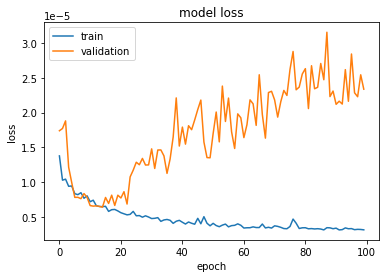

In [244]:
#6.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [241]:
prediction_unscaled=scaler_y.inverse_transform(predictions)
sklearn.metrics.mean_squared_error(y_val, prediction_unscaled)

468.2364019079433

In [242]:
mean_absolute_error(y_val, prediction_unscaled)

4.835910759401304

# Je suis un encule

In [233]:
#4. Setting up the model
num_features=x.shape[1]
hidden_layers=2/3*(num_features+1)

simpler_model_two_hidden_layers = Sequential()
simpler_model_two_hidden_layers.add(Dense(num_features, input_dim=num_features, kernel_initializer='normal', activation='relu'))
simpler_model_two_hidden_layers.add(Dense(hidden_layers, activation='relu'))
simpler_model_two_hidden_layers.add(Dense(hidden_layers, activation='relu'))
simpler_model_two_hidden_layers.add(Dense(1, activation='linear'))
simpler_model_two_hidden_layers.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_21 (Dense)             (None, 19)                551       
_________________________________________________________________
dense_22 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 20        
Total params: 1,763
Trainable params: 1,763
Non-trainable params: 0
_________________________________________________________________


In [237]:
epoch=100
batch=x.shape[0]

simpler_model_two_hidden_layers.compile(loss='mse', optimizer='adam', metrics=['mse','mae']) # mean_squared_error (mse) and mean_absolute_error (mae) are our loss functions
history=simpler_model_two_hidden_layers.fit(xtrain_scale, ytrain_scale, epochs=epoch, batch_size=batch, verbose=1, validation_split=0.2)
predictions = simpler_model_two_hidden_layers.predict(xval_scale)

Epoch 1/100
1/1 [==============================] - 0s 113ms/step - loss: 1.3882e-04 - mse: 1.3882e-04 - mae: 0.0090 - val_loss: 2.1381e-04 - val_mse: 2.1381e-04 - val_mae: 0.0062
Epoch 2/100
1/1 [==============================] - 0s 17ms/step - loss: 8.7170e-05 - mse: 8.7170e-05 - mae: 0.0061 - val_loss: 1.8598e-04 - val_mse: 1.8598e-04 - val_mae: 0.0039
Epoch 3/100
1/1 [==============================] - 0s 19ms/step - loss: 6.2546e-05 - mse: 6.2546e-05 - mae: 0.0038 - val_loss: 1.7578e-04 - val_mse: 1.7578e-04 - val_mae: 0.0027
Epoch 4/100
1/1 [==============================] - 0s 20ms/step - loss: 5.6422e-05 - mse: 5.6422e-05 - mae: 0.0026 - val_loss: 1.7370e-04 - val_mse: 1.7370e-04 - val_mae: 0.0031
Epoch 5/100
1/1 [==============================] - 0s 21ms/step - loss: 5.8053e-05 - mse: 5.8053e-05 - mae: 0.0030 - val_loss: 1.7211e-04 - val_mse: 1.7211e-04 - val_mae: 0.0033
Epoch 6/100
1/1 [==============================] - 0s 21ms/step - loss: 5.9903e-05 - mse: 5.9903e-05 - mae: 0

Epoch 47/100
1/1 [==============================] - 0s 29ms/step - loss: 2.1377e-05 - mse: 2.1377e-05 - mae: 9.9868e-04 - val_loss: 6.4101e-05 - val_mse: 6.4101e-05 - val_mae: 0.0010
Epoch 48/100
1/1 [==============================] - 0s 20ms/step - loss: 2.1085e-05 - mse: 2.1085e-05 - mae: 9.9087e-04 - val_loss: 6.1607e-05 - val_mse: 6.1607e-05 - val_mae: 0.0010
Epoch 49/100
1/1 [==============================] - 0s 21ms/step - loss: 2.0843e-05 - mse: 2.0843e-05 - mae: 0.0010 - val_loss: 5.9233e-05 - val_mse: 5.9233e-05 - val_mae: 0.0011
Epoch 50/100
1/1 [==============================] - 0s 23ms/step - loss: 2.0613e-05 - mse: 2.0613e-05 - mae: 0.0010 - val_loss: 5.6949e-05 - val_mse: 5.6949e-05 - val_mae: 0.0011
Epoch 51/100
1/1 [==============================] - 0s 26ms/step - loss: 2.0428e-05 - mse: 2.0428e-05 - mae: 0.0010 - val_loss: 5.4750e-05 - val_mse: 5.4750e-05 - val_mae: 0.0011
Epoch 52/100
1/1 [==============================] - 0s 24ms/step - loss: 2.0283e-05 - mse: 2.0283

1/1 [==============================] - 0s 20ms/step - loss: 1.4426e-05 - mse: 1.4426e-05 - mae: 8.0481e-04 - val_loss: 2.7581e-05 - val_mse: 2.7581e-05 - val_mae: 8.0019e-04
Epoch 92/100
1/1 [==============================] - 0s 20ms/step - loss: 1.4292e-05 - mse: 1.4292e-05 - mae: 7.9603e-04 - val_loss: 2.6993e-05 - val_mse: 2.6993e-05 - val_mae: 8.1412e-04
Epoch 93/100
1/1 [==============================] - 0s 19ms/step - loss: 1.4191e-05 - mse: 1.4191e-05 - mae: 8.1037e-04 - val_loss: 2.6441e-05 - val_mse: 2.6441e-05 - val_mae: 8.2183e-04
Epoch 94/100
1/1 [==============================] - 0s 19ms/step - loss: 1.4104e-05 - mse: 1.4104e-05 - mae: 8.1841e-04 - val_loss: 2.5883e-05 - val_mse: 2.5883e-05 - val_mae: 8.1436e-04
Epoch 95/100
1/1 [==============================] - 0s 19ms/step - loss: 1.4007e-05 - mse: 1.4007e-05 - mae: 8.1162e-04 - val_loss: 2.5329e-05 - val_mse: 2.5329e-05 - val_mae: 7.9492e-04
Epoch 96/100
1/1 [==============================] - 0s 18ms/step - loss: 1.389

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


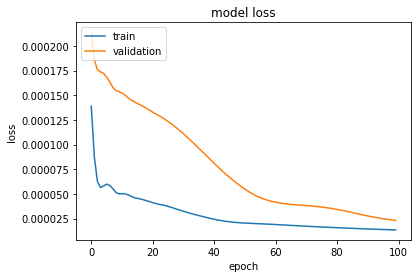

In [238]:
#6.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [239]:
prediction_unscaled=scaler_y.inverse_transform(predictions)
sklearn.metrics.mean_squared_error(y_val, prediction_unscaled)

501.6009667487024

# En dessous de ça on s'en balec

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


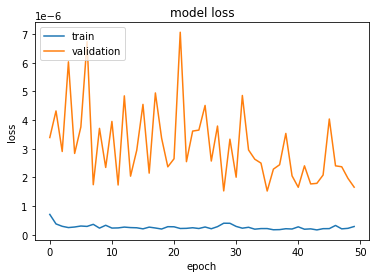

In [99]:
#6.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


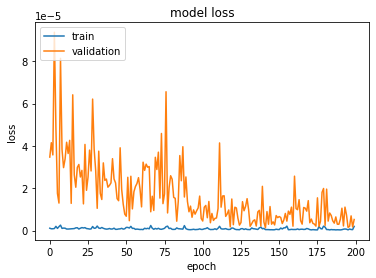

In [93]:
#6.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


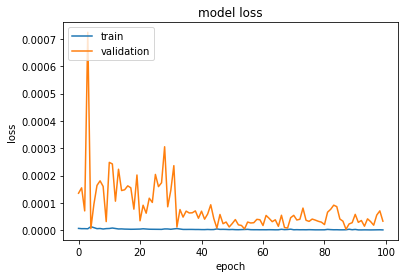

In [91]:
#6.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


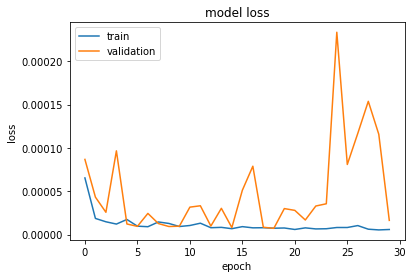

In [39]:
#6.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [100]:
prediction_unscaled=scaler_y.inverse_transform(predictions)
sklearn.metrics.mean_squared_error(y_val, prediction_unscaled)

262.723082996859

In [95]:
comparaison=pd.concat([pd.DataFrame(prediction_unscaled).rename(columns={0:'prediction'}),pd.DataFrame(y_val).rename(columns={0:'y_val'})],axis=1)

comparaison['absolute_diff']=comparaison.apply(lambda x: (x['prediction']-x['y_val'])**2,axis=1)
comparaison['relative_diff']=comparaison.apply(lambda x: x['absolute_diff']/(x['prediction']**2),axis=1)
comparaison.head()

,prediction,y_val,absolute_diff,relative_diff
0,141.599411,110,998.522776,0.049801
1,-0.141118,0,0.019914,1.000000
2,-0.141118,0,0.019914,1.000000
3,17.675032,13,21.855921,0.069960
4,-0.141118,0,0.019914,1.000000


In [96]:
comparaison.describe()

,prediction,y_val,absolute_diff,relative_diff
count,11526.000000,11526.000000,1.152600e+04,1.152600e+04
mean,9.712377,8.973712,4.149077e+02,1.013425e+02
std,62.783829,49.614875,1.574335e+04,5.956349e+03
min,-25.213772,0.000000,2.260115e-07,3.433703e-09
25%,-0.141118,0.000000,1.991431e-02,6.468449e-02
50%,-0.141118,0.000000,1.991431e-02,1.000000e+00
75%,2.796188,3.000000,6.021014e-01,1.000000e+00
max,3379.122314,2653.000000,1.418173e+06,5.883183e+05


In [150]:
comparaison['absolute_diff'].sum()/y_val.size

135.70134429570572

11526

# Research

In [11]:
#Could be a solution to solve the categorisation problem

df=pd.read_csv("./challenge_youtube_toxic.csv", sep=";",encoding = 'latin1')

categ_inst=df.categ_inst.astype("category").cat.codes
categ_inst=pd.Series(categ_inst)
categ_inst.unique()

array([4, 5, 3, 2, 1, 0], dtype=int8)

# Best Tuto ever pour Prediction Neural Network : https://towardsdatascience.com/regression-based-neural-networks-with-tensorflow-v2-0-predicting-average-daily-rates-e20fffa7ac9a

In [127]:
#5. Using the model
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae']) # mean_squared_error (mse) and mean_absolute_error (mae) are our loss functions
history=model.fit(xtrain_scale, ytrain_scale, epochs=50, batch_size=150, verbose=1, validation_split=0.2)
predictions = model.predict(xval_scale)

Epoch 1/50
185/185 [==============================] - 0s 2ms/step - loss: 1.9528e-07 - mse: 1.9528e-07 - mae: 2.0972e-04 - val_loss: 7.7847e-06 - val_mse: 7.7847e-06 - val_mae: 3.0627e-04
Epoch 2/50
185/185 [==============================] - 0s 1ms/step - loss: 2.3775e-07 - mse: 2.3775e-07 - mae: 2.1955e-04 - val_loss: 7.5658e-06 - val_mse: 7.5658e-06 - val_mae: 2.0531e-04
Epoch 3/50
185/185 [==============================] - 0s 1ms/step - loss: 1.6042e-07 - mse: 1.6042e-07 - mae: 1.8620e-04 - val_loss: 8.4396e-06 - val_mse: 8.4396e-06 - val_mae: 2.5011e-04
Epoch 4/50
185/185 [==============================] - 0s 1ms/step - loss: 1.2152e-07 - mse: 1.2152e-07 - mae: 1.6218e-04 - val_loss: 5.8213e-06 - val_mse: 5.8213e-06 - val_mae: 2.1067e-04
Epoch 5/50
185/185 [==============================] - 0s 1ms/step - loss: 1.7923e-07 - mse: 1.7923e-07 - mae: 1.8849e-04 - val_loss: 7.8779e-06 - val_mse: 7.8779e-06 - val_mae: 3.1747e-04
Epoch 6/50
185/185 [==============================] - 0s 1ms